
#Loading dataset and creating segmentation model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import glob
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from tensorflow.keras.optimizers import Adam
from keras.layers import Input 
from tensorflow.keras import layers
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report,confusion_matrix
import joblib

In [ ]:
!nvidia-smi

Thu Sep 15 17:58:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Load data and paths
data = pd.read_csv('/content/drive/MyDrive/Projekt/WaterMeters/data.csv')
images_folder = "/content/drive/MyDrive/Projekt/WaterMeters/images/"
masks_folder = "/content/drive/MyDrive/Projekt/WaterMeters/masks/"
coll_folder = "/content/drive/MyDrive/Projekt/WaterMeters/collage/"

In [ ]:
print(f'Total number of images: {len(os.listdir(images_folder))}')
print(f'Total number of image masks: {len(os.listdir(masks_folder))}')
print(f'Total number of collages: {len(os.listdir(coll_folder))}')
print(f'Length of dataset: {len(data)}')

Total number of images: 1244
Total number of image masks: 1244
Total number of collages: 1244
Length of dataset: 1244


Display of loaded images and their masks and collage images with a segmented counter

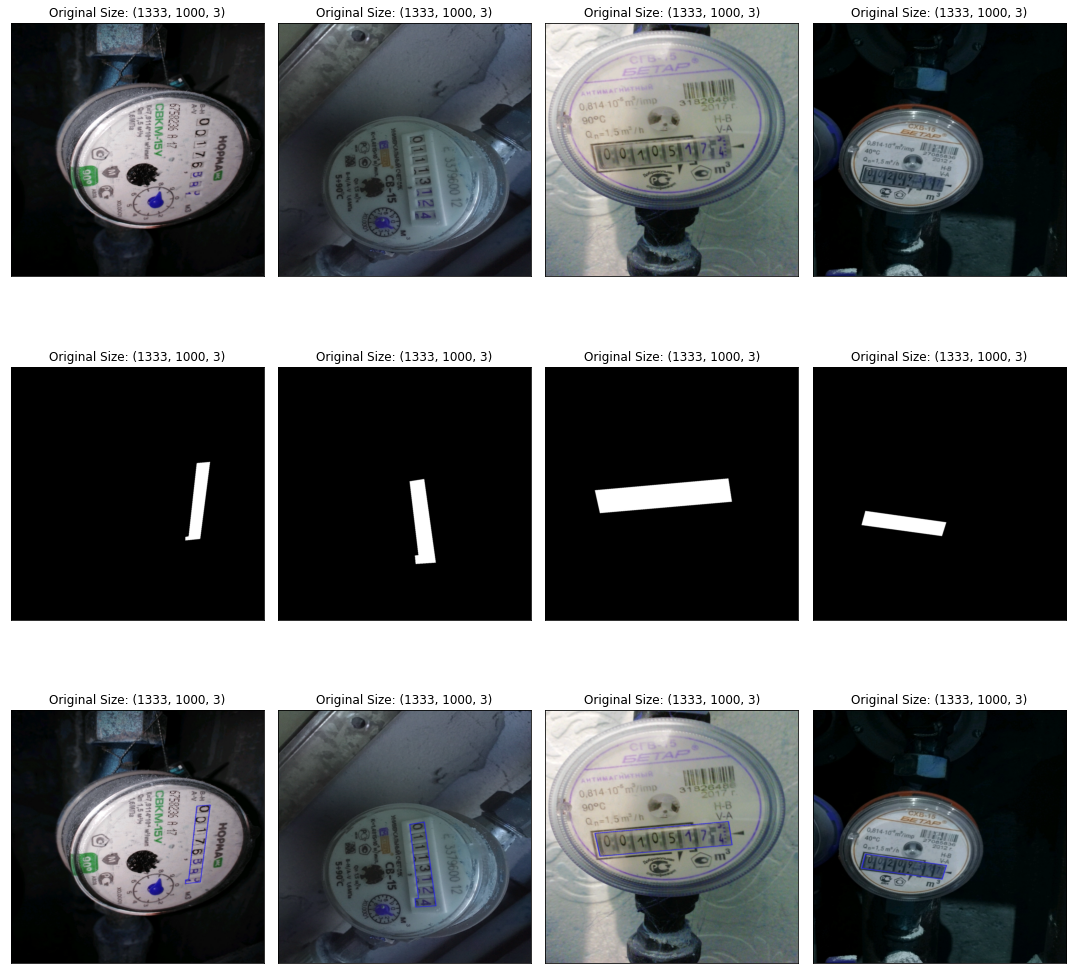

In [ ]:
#Create figure and empty list for axes
axes=[]
fig=plt.figure(figsize=(15, 15))
i=0
#Show first 4 images in dataset with corresponding shape.
for i in range(4):
    #Obtain file name and create path.
    file = sorted(os.listdir(images_folder))[i]
    image_path = os.path.join(images_folder, file) 

    #Read the file image and resize it for show.
    img = cv2.imread(image_path)
    resized_image = cv2.resize(img, (700, 700), interpolation = cv2.INTER_AREA)
    #Print the resized image and dislpay the shape.
    axes.append(fig.add_subplot(3, 4, i+1) )
    subplot_title=(f"Original Size: {img.shape}")
    axes[-1].set_title(subplot_title)  
    plt.imshow(resized_image)
    
for i in range(4):
    #Obtain file name and create path.
    file = sorted(os.listdir(masks_folder))[i]
    image_path = os.path.join(masks_folder, file) 

    #Read the file image and resize it for show.
    img = cv2.imread(image_path)
    resized_image = cv2.resize(img, (700, 700), interpolation = cv2.INTER_AREA)
    #Print the resized image and dislpay the shape.
    axes.append(fig.add_subplot(3, 4, i+5) )
    subplot_title=(f"Original Size: {img.shape}")
    axes[-1].set_title(subplot_title) 
    plt.imshow(resized_image)
    
for i in range(4):
    #Obtain file name and create path.
    file = sorted(os.listdir(coll_folder))[i]
    image_path = os.path.join(coll_folder, file) 

    #Read the file image and resize it for show.
    img = cv2.imread(image_path)
    resized_image = cv2.resize(img, (700, 700), interpolation = cv2.INTER_AREA)
    #Print the resized image and dislpay the shape.
    axes.append(fig.add_subplot(3, 4, i+9) )
    subplot_title=(f"Original Size: {img.shape}")
    axes[-1].set_title(subplot_title)
    plt.imshow(resized_image)
    
#Remove ticks from each image.
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

#Plot the image.
fig.tight_layout()    
plt.show()

Create an np array of the desired dimensions on which to train the model and resize the images and save them in folders
so that we don't have to resize the images every time when building the model

In [ ]:
y = np.zeros((1244, 512, 512), dtype='float32')
X = np.zeros((1244, 512, 512, 3), dtype='float32') 

In [ ]:
images_resized_folder = "/content/drive/MyDrive/Projekt/WaterMeters/images_resized/"
masks_resized_folder = "/content/drive/MyDrive/Projekt/WaterMeters/masks_resized/"
coll_resized_folder = "/content/drive/MyDrive/Projekt/WaterMeters/collage_resized/"

In [ ]:
path = images_resized_folder #the path where to save resized images
# create new folder
if not os.path.exists(path):
    os.makedirs(path)

# loop over existing images and resize
# change path to your path
for filename in glob.glob(images_folder+'*.jpg'): #path of raw images
    name=filename.rsplit('/', 1)[-1]
    img = cv2.imread(filename)
    img = cv2.resize(img, (512, 512))
    cv2.imwrite(path+name,img)
    # save resized images to new folder with existing filename

    #img = Image.open(filename).resize((512,512))
    #img.save('{}{}{}'.format(path,'/',os.path.split(filename)[1]))

In [ ]:
path = masks_resized_folder
if not os.path.exists(path):
    os.makedirs(path)

for filename in glob.glob(masks_folder+'*.jpg'):
    name=filename.rsplit('/', 1)[-1]
    img = cv2.imread(filename)
    img = cv2.resize(img, (512, 512))
    #image normalization
    img = 1.0 * (img[:, :, 0] > .1)

    cv2.imwrite(path+name,img)

In [ ]:
path = coll_resized_folder
if not os.path.exists(path):
    os.makedirs(path)

for filename in glob.glob(coll_folder+'/*.jpg'):
    name=filename.rsplit('/', 1)[-1]
    img = cv2.imread(filename)
    img = cv2.resize(img, (512, 512))
    cv2.imwrite(path+name,img)

In [ ]:
#adding images to array 
i=0
for filename in sorted(glob.glob(images_resized_folder+'*.jpg')):
    img = cv2.imread(filename)
    X[i] = img
    i+=1
i=0
for filename in sorted(glob.glob(masks_resized_folder+'*.jpg')):
    img = cv2.imread(filename)
    img = 1.0 * (img[:, :, 0] > .1)
    y[i]=img
    i+=1

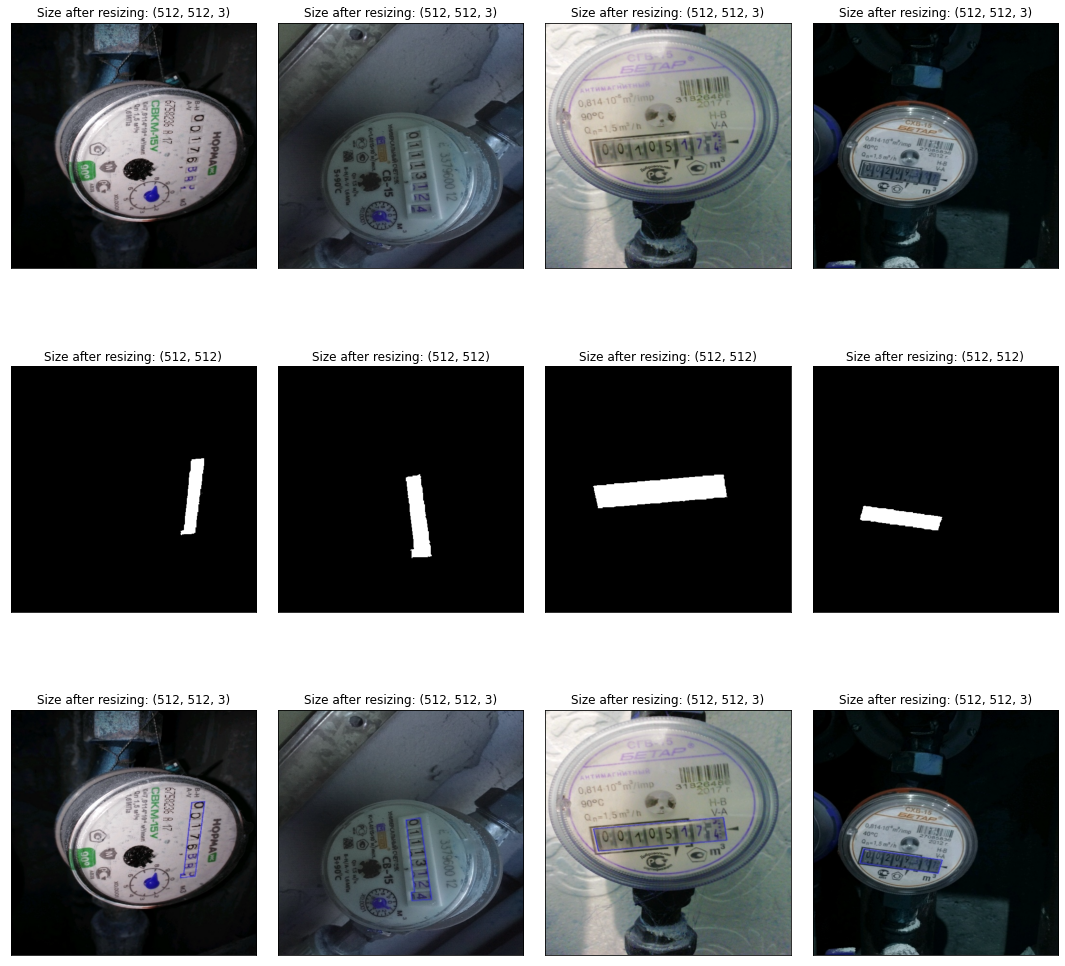

In [ ]:
axes=[]
fig=plt.figure(figsize=(15, 15))

for i in range(4):
    img = X[i]
    axes.append(fig.add_subplot(3, 4, i+1) )
    subplot_title=(f"Size after resizing: { img.shape}")
    axes[-1].set_title(subplot_title)  
    plt.imshow(img.astype(np.uint8))
    
for i in range(4):
    img = y[i]
    axes.append(fig.add_subplot(3, 4, i+5) )
    subplot_title=(f"Size after resizing: { img.shape}")
    axes[-1].set_title(subplot_title)  
    plt.imshow(img.astype(np.uint8), 'gray')
    
for i in range(4):
    file = sorted(os.listdir(coll_folder))[i]
    image_path = os.path.join(coll_resized_folder, file) 
    
    img = cv2.imread(image_path)
    
    axes.append(fig.add_subplot(3, 4, i+9) )
    subplot_title=(f"Size after resizing: {img.shape}")
    axes[-1].set_title(subplot_title)
    plt.imshow(img)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout() 
plt.show()

In [ ]:
#dividing data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
#freeing X and y variables because we wont use them any more
del X
del y

In [ ]:
#model definition
def unet_model ():
  inputs = layers.Input(shape=(512,512,3))
  s = Lambda(lambda x: x / 255) (inputs)

  c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
  a1 = BatchNormalization()(s)

  c1 = Dropout(0.1) (a1)
  c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
  a2 = BatchNormalization()(c1)
  p1 = MaxPooling2D((2, 2)) (a2)

  c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
  a3 = BatchNormalization()(c2)
  c2 = Dropout(0.1) (a3)
  c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
  a4 = BatchNormalization()(c2)
  p2 = MaxPooling2D((2, 2)) (a4)

  c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
  a5 = BatchNormalization()(c3)
  c3 = Dropout(0.2) (a5)
  c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
  a6 = BatchNormalization()(c3)
  p3 = MaxPooling2D((2, 2)) (a6)

  c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
  a7 = BatchNormalization()(c4)
  c4 = Dropout(0.2) (a7)
  c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
  a8 = BatchNormalization()(c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (a8)

  c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
  a9 = BatchNormalization()(c5)
  c5 = Dropout(0.3) (a9)
  c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
  a10 = BatchNormalization()(c5)

  u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (a10)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
  a11 = BatchNormalization()(c6)
  c6 = Dropout(0.2) (a11)
  c6 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)
  a12 = BatchNormalization()(c6)

  u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (a12)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
  a13 = BatchNormalization()(c7)
  c7 = Dropout(0.2) (a13)
  c7 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)
  a14 = BatchNormalization()(c7)

  u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (a14)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
  a15 = BatchNormalization()(c8)
  c8 = Dropout(0.1) (a15)
  c8 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)
  a16 = BatchNormalization()(c8)

  u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (a16)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
  a17 = BatchNormalization()(c9)
  c9 = Dropout(0.1) (a17)
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)
  

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
  
  model = Model(inputs=[inputs], outputs=[outputs])

  return model

In [ ]:
#building model

model = unet_model()
#model checpoint allows us to save the best model after every epoch 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/Projekt/model.hdf5',
    save_weights_only=False,
    monitor='val_binary_io_u',
    mode='max',
    save_best_only=True,
    verbose=1,
    save_freq="epoch" )
#early_stopping allows us to monitor model improvements and stop training when there is no improvements to the model so it doesn't overtrain
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_binary_io_u', patience=8, min_delta=0.05)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),loss="binary_crossentropy",metrics=tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 3)  12         ['lambda[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size = 8, callbacks=[model_checkpoint_callback, early_stopping])

In [ ]:
model=load_model('/content/drive/MyDrive/Projekt/model.hdf5')

(512, 512, 3)
1/1 [==============================] - 3s 3s/step


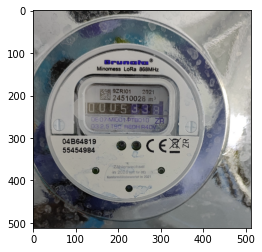

(512, 512, 1)


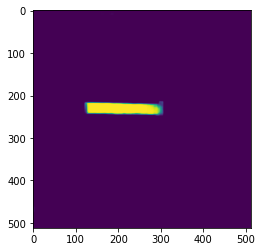

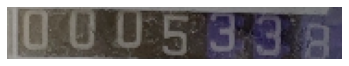

(28, 181, 3)


In [ ]:
#Predict on a custom image
img = cv2.imread('/content/drive/MyDrive/Projekt/WaterMeters/Samostalno_prikupljene_slike/voda1.jpg')
img = cv2.resize(img, (512, 512))
print(img.shape)
T = np.zeros((1, 512, 512, 3), dtype='float32')
T[0]=img
prediction = model.predict(T , verbose=1)
prediction = prediction[0, :, : , :]
plt.imshow(img)
plt.show()
print(prediction.shape)
plt.imshow(np.squeeze(prediction).astype(np.float32))
plt.show()

prediction = np.squeeze(prediction).astype(np.float32)
threshold = 0.4
xmin,ymin,xmax,ymax = (-1,-1,-1,-1)
for j in range(512):
    for i in range(512):
        if prediction[j,i] <= threshold: continue
        xmin = i if xmin == -1 or xmin > i else xmin
        xmax = i if xmax == -1 or xmax < i else xmax
        ymin = j if ymin == -1 or ymin > j else ymin
        ymax = j if ymax == -1 or ymax < j else ymax 
cropImg = img[ymin:ymax,xmin:xmax]
plt.axis('off')
plt.imshow(cropImg )
plt.show()
print(cropImg.shape)



#Creating Tflite model for object detection

In [ ]:
#collecting images for annotations
k=0
for filename in sorted(glob.glob(images_resized_folder+'*.jpg')): #path of raw images
    print(k)
    img = cv2.imread(filename)
    img = cv2.resize(img, (512, 512))
    T = np.zeros((1, 512, 512, 3), dtype='float32')
    T[0]=img
    prediction = model.predict(T , verbose=1)
    prediction = prediction[0, :, : , :]

    prediction = np.squeeze(prediction).astype(np.float32)
    threshold = 0.4
    xmin,ymin,xmax,ymax = (-1,-1,-1,-1)
    for j in range(512):
        for i in range(512):
            if prediction[j,i] <= threshold: continue
            xmin = i if xmin == -1 or xmin > i else xmin
            xmax = i if xmax == -1 or xmax < i else xmax
            ymin = j if ymin == -1 or ymin > j else ymin
            ymax = j if ymax == -1 or ymax < j else ymax 
    cropImg = img[ymin:ymax,xmin:xmax]
    cropImg = cv2.resize(cropImg, (224, 224))
    cv2.imwrite('/content/drive/MyDrive/Projekt/WaterMeters/Anotacije2/'+str(k)+'.jpg',cropImg)
    k=k+1
    if k>250:
      break
    else:
      continue


In [ ]:
#after selecting higher quality images we rerun this code so images are sorted by name correctly
k=0
for filename in sorted(glob.glob('/content/drive/MyDrive/Projekt/WaterMeters/Anotacije2/'+'*.jpg')): #path of raw images
    print(k)
    img = cv2.imread(filename)
    cv2.imwrite('/content/drive/MyDrive/Projekt/WaterMeters/Anotacije2_1/'+str(k)+'.jpg',img)
    k=k+1


In [ ]:
!pip install -q tflite-model-maker
!pip install -q tflite-support

     |████████████████████████████████| 577 kB 5.1 MB/s 
     |████████████████████████████████| 60.2 MB 55.0 MB/s 
     |████████████████████████████████| 238 kB 72.6 MB/s 
     |████████████████████████████████| 840 kB 42.6 MB/s 
     |████████████████████████████████| 128 kB 48.9 MB/s 
     |████████████████████████████████| 1.3 MB 67.0 MB/s 
     |████████████████████████████████| 87 kB 7.1 MB/s 
     |████████████████████████████████| 10.9 MB 44.2 MB/s 
     |████████████████████████████████| 3.4 MB 55.3 MB/s 
     |████████████████████████████████| 77 kB 4.5 MB/s 
     |████████████████████████████████| 1.1 MB 50.0 MB/s 
     |████████████████████████████████| 25.3 MB 84.1 MB/s 
     |████████████████████████████████| 352 kB 77.2 MB/s 
     |████████████████████████████████| 99 kB 6.5 MB/s 
     |████████████████████████████████| 40 kB 5.4 MB/s 
     |████████████████████████████████| 1.1 MB 58.1 MB/s 
     |████████████████████████████████| 213 kB 50.6 MB/s 


In [ ]:
from tflite_model_maker.config import ExportFormat, QuantizationConfig
from tflite_model_maker import object_detector
from tflite_model_maker import model_spec
from tflite_support import metadata

import tensorflow_hub as hub

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

In [ ]:
#Loading images and their anotations in voc xml format and setting classes
train_data = object_detector.DataLoader.from_pascal_voc(
    '/content/drive/MyDrive/Projekt/WaterMeters/Anotacije2_1/train',
    '/content/drive/MyDrive/Projekt/WaterMeters/Anotacije2_1/train',
    ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
)

val_data = object_detector.DataLoader.from_pascal_voc(
    '/content/drive/MyDrive/Projekt/WaterMeters/Anotacije2_1/test',
    '/content/drive/MyDrive/Projekt/WaterMeters/Anotacije2_1/test',
    ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
)   
spec = model_spec.get('efficientdet_lite4')

In [ ]:
#Building model and training
model_numbers = object_detector.create(train_data, model_spec=spec, batch_size=1, train_whole_model=True, epochs=100, validation_data=val_data)

In [ ]:
model_numbers.evaluate(val_data)
#Although our model shows quite good precision, the number of images and their quality is probably not sufficient for great precision in our images

In [ ]:
model_numbers.export(export_dir='/content/drive/MyDrive/Projekt', tflite_filename='model_numbers.tflite') 

In [ ]:
#Only run this block if the model is not already loaded
#We need to load classes into model
from tflite_model_maker.config import ExportFormat, QuantizationConfig
from tflite_model_maker import object_detector
from tflite_model_maker import model_spec
from tflite_support import metadata
import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

train_data = object_detector.DataLoader.from_pascal_voc(
    '/content/drive/MyDrive/Projekt/WaterMeters/Anotacije2_1/train',
    '/content/drive/MyDrive/Projekt/WaterMeters/Anotacije2_1/train',
    ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
)

val_data = object_detector.DataLoader.from_pascal_voc(
    '/content/drive/MyDrive/Projekt/WaterMeters/Anotacije2_1/test',
    '/content/drive/MyDrive/Projekt/WaterMeters/Anotacije2_1/test',
    ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
)   
spec = model_spec.get('efficientdet_lite4')
model_numbers = object_detector.create(train_data, model_spec=spec, validation_data=val_data , batch_size=1, epochs=0)

In [ ]:
# Load the labels into a list
classes = ['???'] * model_numbers.model_spec.config.num_classes
label_map = model_numbers.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Retur the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  # Feed the input image to the model
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all outputs from the model
  scores = get_output_tensor(interpreter, 0)
  boxes = get_output_tensor(interpreter, 1)
  count = int(get_output_tensor(interpreter, 2))
  classes = get_output_tensor(interpreter, 3)

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path, 
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute 
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8


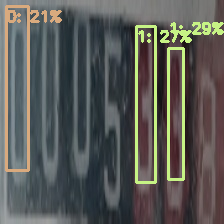

In [ ]:
iimg = cv2.resize(cropImg, (224, 224))
cv2.imwrite('1.jpg', iimg)
INPUT_IMAGE_URL = '1.jpg'
DETECTION_THRESHOLD = 0.2

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/Projekt/model_numbers.tflite')
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    INPUT_IMAGE_URL, 
    interpreter, 
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)

#Easyocr on segmented image

In [ ]:
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 4.0 MB/s 
     |████████████████████████████████| 604 kB 52.5 MB/s 
     |████████████████████████████████| 47.6 MB 2.3 MB/s 
     |████████████████████████████████| 108 kB 57.0 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66


In [ ]:
import easyocr

In [ ]:
reader = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

[([[0, 0], [173, 0], [173, 35], [0, 35]], '1000533', 0.7960896883455622)]


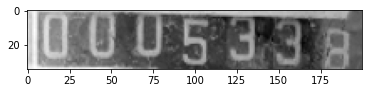

In [ ]:
#This is the most accurate readings thtat we got from our images
img3 = cv2.resize(cropImg, (200, 35))
img3 = cv2.cvtColor(img3,cv2.COLOR_RGB2GRAY)


numbers=reader.readtext(img3, allowlist='0123456789')
print(numbers)

#edges= cv2.Canny(img3,100,200)
plt.imshow(img3,'gray')
plt.show()


#Creating MNIST model

Slika sadrzi broj: 7


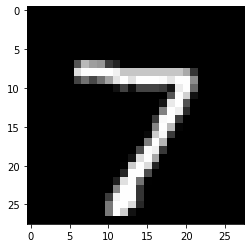

Iteration 1, loss = 0.52524751
Iteration 2, loss = 0.23743295
Iteration 3, loss = 0.18408138
Iteration 4, loss = 0.15014345
Iteration 5, loss = 0.12629492
Iteration 6, loss = 0.10910470
Iteration 7, loss = 0.09537998
Iteration 8, loss = 0.08420833
Iteration 9, loss = 0.07462553
Iteration 10, loss = 0.06743002
Iteration 11, loss = 0.06052063
Iteration 12, loss = 0.05495399
Iteration 13, loss = 0.04964197
Iteration 14, loss = 0.04553676
Iteration 15, loss = 0.04113852
Iteration 16, loss = 0.03792769
Iteration 17, loss = 0.03461621
Iteration 18, loss = 0.03208837
Iteration 19, loss = 0.02949273
Iteration 20, loss = 0.02693418
Iteration 21, loss = 0.02498707
Iteration 22, loss = 0.02302910
Iteration 23, loss = 0.02134679
Iteration 24, loss = 0.01985755
Iteration 25, loss = 0.01832074
Iteration 26, loss = 0.01729559
Iteration 27, loss = 0.01612314
Iteration 28, loss = 0.01511923
Iteration 29, loss = 0.01409363
Iteration 30, loss = 0.01322643
Iteration 31, loss = 0.01258675
Iteration 32, los

['/content/drive/MyDrive/Projekt/model_mnist.hdf5']

In [ ]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)


# Showing random image and value 
imgNumber=60000
plt.figure(1)
plt.imshow(np.reshape(X[imgNumber,:],(28,28)),cmap='gray')
print("Slika sadrzi broj:",y[imgNumber])
plt.show()

# skaliraj podatke, train/test split
X = X / 255.
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

# training model with sckitlearn MPLClassifier 
mlp_mnist=MLPClassifier(hidden_layer_sizes=(500,500),activation='relu',max_iter=100,alpha=1e-3,momentum=0.9,solver='sgd',verbose=10,random_state=1,learning_rate_init=0.01)
mlp_mnist.fit(X_train,y_train)

# evaluating model

predict_train = mlp_mnist.predict(X_train)
predict_test = mlp_mnist.predict(X_test)
print(confusion_matrix(y_test,predict_test))
print(classification_report(y_test,predict_test))

# saving model
filename = "/content/drive/MyDrive/Projekt/model_mnist.hdf5"
joblib.dump(mlp_mnist, filename)




In [ ]:
model_mnist=joblib.load('/content/drive/MyDrive/Projekt/model_mnist.hdf5')

Pre processing image and finding edges to segment digits

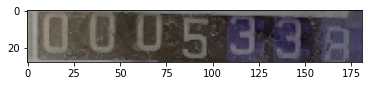

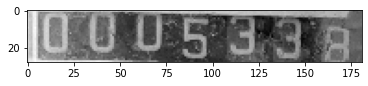

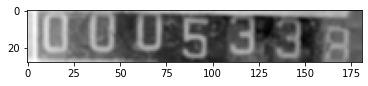

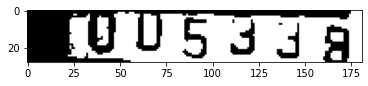

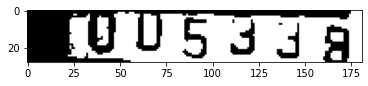

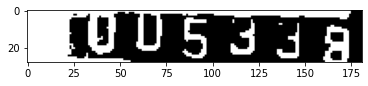

(160, 8, 14, 20)
['2']


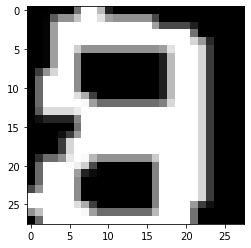

(135, 7, 12, 19)
['3']


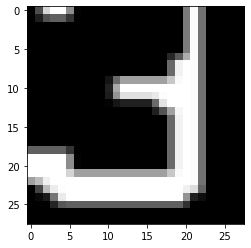

(110, 5, 13, 19)
['3']


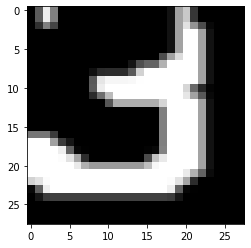

(84, 4, 13, 22)
['5']


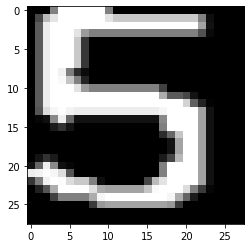

In [ ]:
image = cropImg
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (3,3), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Morph open to remove noise and invert image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
invert = 255 - opening

contours, hierarchy = cv2.findContours(invert,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

plt.imshow(image)
plt.show()
plt.imshow(gray,'gray')
plt.show()
plt.imshow(blur,'gray')
plt.show()
plt.imshow(thresh,'gray')
plt.show()
plt.imshow(opening,'gray')
plt.show()
plt.imshow(invert,'gray')
plt.show()

''' data = pytesseract.image_to_string(invert, lang='eng', config='--psm 6 , tessedit_char_whitelist=0123456789.,')
print(data)   '''

pad = 3
mnist_size = 28

rects = [cv2.boundingRect(contour) for contour in contours]
rects = [rect for rect in rects if rect[2] >= 11 and rect[3] >= 11 and rect[2] <= 95 and rect[3] <= 95]


for rect in rects:
    
    x, y, w, h = rect
    print(rect)
    #crop rectangle from image        
    cropped_digit = invert[y:y+h+pad, x:x+w+pad]
    cropped_digit = cropped_digit/255.0

    #filter small rectangles:
    if cropped_digit.shape[0] >= 8 and cropped_digit.shape[1] >= 8:
        cropped_digit = cv2.resize(cropped_digit, (mnist_size, mnist_size))
        img_vector = cropped_digit.reshape(1,mnist_size*mnist_size)
        

        print(model_mnist.predict(img_vector))   
        plt.imshow(cropped_digit,'gray')
        plt.show()

    else:
        continue
#Image pre processing is different for every image and that is the reason that we can't get segmented digits right

(512, 512, 3)
1/1 [==============================] - 3s 3s/step


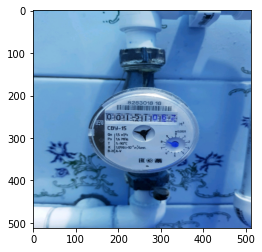

(512, 512, 1)


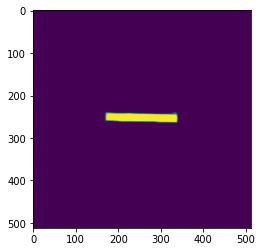

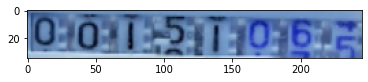

(35, 245, 3)


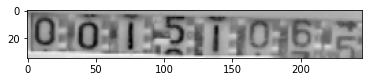

(35, 245)


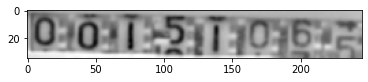

(35, 245)


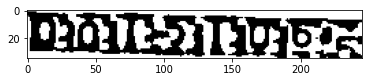

(35, 245)


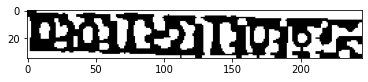

(35, 245)
(170, 14, 15, 21)
['3']


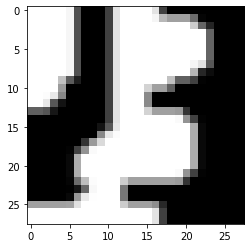

(93, 14, 18, 14)
['8']


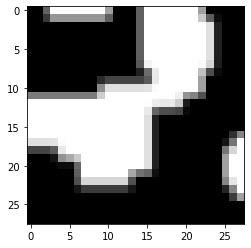

(141, 9, 12, 23)
['8']


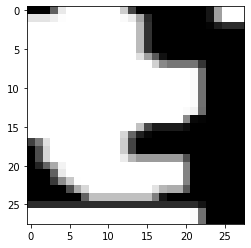

(112, 8, 11, 21)
['8']


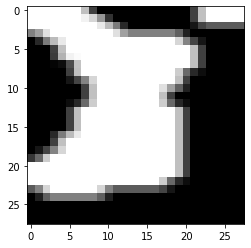

(78, 7, 13, 21)
['8']


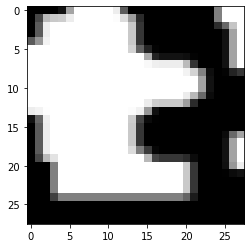

(49, 6, 11, 16)
['6']


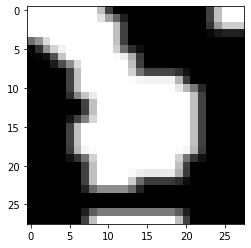

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Projekt/WaterMeters/images/id_322_value_151_065.jpg')
img = cv2.resize(img, (512, 512))
print(img.shape)
T = np.zeros((1, 512, 512, 3), dtype='float32')
T[0]=img
prediction = model.predict(T , verbose=1)
prediction = prediction[0, :, : , :]
plt.imshow(img)
plt.show()
print(prediction.shape)
plt.imshow(np.squeeze(prediction).astype(np.float32))
plt.show()

prediction = np.squeeze(prediction).astype(np.float32)
threshold = 0.4
xmin,ymin,xmax,ymax = (-1,-1,-1,-1)
for j in range(512):
    for i in range(512):
        if prediction[j,i] <= threshold: continue
        xmin = i if xmin == -1 or xmin > i else xmin
        xmax = i if xmax == -1 or xmax < i else xmax
        ymin = j if ymin == -1 or ymin > j else ymin
        ymax = j if ymax == -1 or ymax < j else ymax
cropImg = img[ymin:ymax,xmin:xmax]

cropImg = cv2.resize(cropImg, (245, 35))

plt.imshow(cropImg)
plt.show()
print(cropImg.shape)

gray_img2 = cv2.cvtColor(cropImg, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img2,'gray')
plt.show()
print(gray_img2.shape)

Gaussianblured = cv2.GaussianBlur(gray_img2, (3, 3), 0)
plt.imshow(Gaussianblured,'gray')
plt.show()
print(Gaussianblured.shape)

thresh = cv2.adaptiveThreshold(Gaussianblured,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,21,1)
#thresh = cv2.adaptiveThreshold(Gaussianblured,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,45,1)
plt.imshow(thresh,'gray')
plt.show()
print(thresh.shape)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
#opening = 255 - opening
plt.imshow(opening,'gray')
plt.show()
print(opening.shape)


contours, hierarchy = cv2.findContours(opening,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
pad = 3
mnist_size = 28

rects = [cv2.boundingRect(contour) for contour in contours]
rects = [rect for rect in rects if rect[2] >= 11 and rect[3] >= 11 and rect[2] <= 35 and rect[3] <= 35]


for rect in rects:
    
    x, y, w, h = rect
    print(rect)
    #crop rectangle from image        
    cropped_digit = opening[y:y+h+pad, x:x+w+pad]
    cropped_digit = cropped_digit/255.0

    #filter small rectangles:
    if cropped_digit.shape[0] >= 8 and cropped_digit.shape[1] >= 8:
        cropped_digit = cv2.resize(cropped_digit, (mnist_size, mnist_size))
        img_vector = cropped_digit.reshape(1,mnist_size*mnist_size)
        

        print(model_mnist.predict(img_vector))   
        plt.imshow(cropped_digit,'gray')
        plt.show()

    else:
        continue

#img_vector2 = gray_img2.reshape(1,28*28)
#print(model_mnist.predict(img_vector2)) 

Attempting to crop images to mnist accepted size
doesn't work because there is a lot of noise in digits and not all images
have the same amount of digits

(512, 512, 3)
1/1 [==============================] - 2s 2s/step


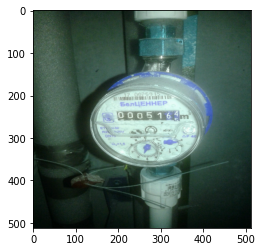

(512, 512, 1)


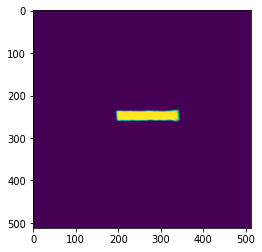

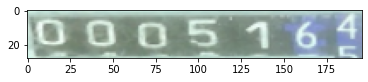

(28, 196, 3)
['9']


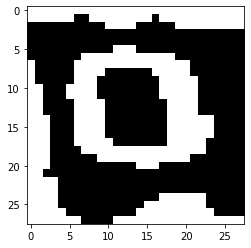

['0']


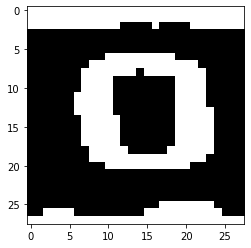

['2']


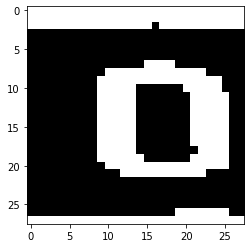

['8']


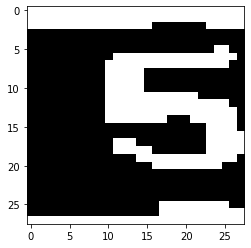

['5']


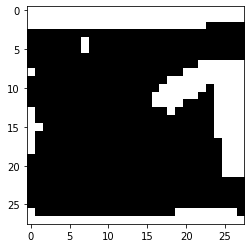

['4']


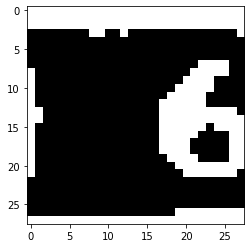

['0']


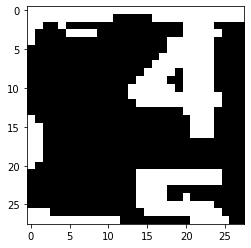

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Projekt/WaterMeters/images/id_1157_value_51_64.jpg')
img = cv2.resize(img, (512, 512))
print(img.shape)
T = np.zeros((1, 512, 512, 3), dtype='float32')
T[0]=img
prediction = model.predict(T , verbose=1)
prediction = prediction[0, :, : , :]
plt.imshow(img)
plt.show()
print(prediction.shape)
plt.imshow(np.squeeze(prediction).astype(np.float32))
plt.show()

prediction = np.squeeze(prediction).astype(np.float32)
threshold = 0.4
xmin,ymin,xmax,ymax = (-1,-1,-1,-1)
for j in range(512):
    for i in range(512):
        if prediction[j,i] <= threshold: continue
        xmin = i if xmin == -1 or xmin > i else xmin
        xmax = i if xmax == -1 or xmax < i else xmax
        ymin = j if ymin == -1 or ymin > j else ymin
        ymax = j if ymax == -1 or ymax < j else ymax
cropImg = img[ymin:ymax,xmin:xmax]

cropImg = cv2.resize(cropImg, (196, 28))
plt.imshow(cropImg)
plt.show()
print(cropImg.shape)


i=0

for i in range(7):
    cropImg2 = cropImg[0:28,28*i:28*(i+1)]
    gray_img3 = cv2.cvtColor(cropImg2, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray_img3,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,21,2)
    img_vector = thresh.reshape(1,mnist_size*mnist_size)
    print(model_mnist.predict(img_vector))

    plt.imshow(thresh,'gray')
    plt.show()
    i=i+1


#Creating a streamlit application with pyngrok

In [3]:
! pip install streamlit -q

     |████████████████████████████████| 9.2 MB 9.1 MB/s 
     |████████████████████████████████| 4.7 MB 31.8 MB/s 
     |████████████████████████████████| 164 kB 49.9 MB/s 
     |████████████████████████████████| 181 kB 44.9 MB/s 
     |████████████████████████████████| 78 kB 4.3 MB/s 
     |████████████████████████████████| 235 kB 46.8 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
     |████████████████████████████████| 51 kB 3.9 MB/s 


In [2]:
! pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 745 kB 7.3 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19007 sha256=b6bfb944e2e1d4e1671c72e2f55642916b14487d21b5f514ae7d585919e9a31b
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok


In [4]:
#Building the app that we are going to deploy
%%writefile app.py

import streamlit as st
import tensorflow as tf
import cv2
import numpy as np
from PIL import Image
import tensorflow_hub as hub

st.set_option('deprecation.showfileUploaderEncoding',False)
@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('/content/drive/MyDrive/Projekt/model.hdf5')
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()


st.write("""
         Segmenting values from meter
         """
         )
file=st.file_uploader("Enter image" , type=["jpg"])

if file is None:
    st.text("Please upload an image file")
else:
    img=Image.open(file)
    img=np.array(img)

    img = cv2.resize(img, (512, 512))
    T = np.zeros((1, 512, 512, 3), dtype='float32')
    T[0]=img
    prediction = model.predict(T , verbose=1)
    prediction = prediction[0, :, : , :]

    st.text('loaded resized image')
    st.image([img])
    st.text('predicted mask')
    st.image([prediction])

    prediction = np.squeeze(prediction).astype(np.float32)
    threshold = 0.4
    xmin,ymin,xmax,ymax = (-1,-1,-1,-1)
    for j in range(512):
        for i in range(512):
            if prediction[j,i] <= threshold: continue
            xmin = i if xmin == -1 or xmin > i else xmin
            xmax = i if xmax == -1 or xmax < i else xmax
            ymin = j if ymin == -1 or ymin > j else ymin
            ymax = j if ymax == -1 or ymax < j else ymax 
    cropImg = img[ymin:ymax,xmin:xmax]
    st.text('cropped prediction')
    st.image([cropImg])
    

Writing app.py


In [5]:
from pyngrok import ngrok

In [6]:
ngrok.set_auth_token("2ElHAixiIejAyq5MpPHGJ6xijw5_4TRVafKmKaQ1iGDX7k4wK")

In [7]:
!nohup streamlit run app.py --server.port 80 &
url = ngrok.connect(port = '80')
print(url)


nohup: appending output to 'nohup.out'
NgrokTunnel: "http://ba12-34-125-235-180.ngrok.io" -> "http://localhost:80"


In [8]:
from pyngrok import ngrok

tunnels = ngrok.get_tunnels()
tunnels
#you need to wait a bit for google colab to open port

[<NgrokTunnel: "https://ba12-34-125-235-180.ngrok.io" -> "http://localhost:80">,
 <NgrokTunnel: "http://ba12-34-125-235-180.ngrok.io" -> "http://localhost:80">]

#Other OCR attempts

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

In [ ]:
import pytesseract

In [ ]:
 !pip install keras-ocr

In [ ]:
 import keras_ocr 